# DEMO: EUCLID-BOX

**Description**: this DEMO allows to compute the Galaxy Clustering and Weak Lensing observational probes as defined in the current recipe and computes the likelihood value given some benchmark data. It uses `Cobaya` as the main Bayesian Analysis tool.

<span style='color:magenta'> Plot section below is great! Perhaps at the start of the notebook we should explicitely say 'In this notebook you will find: three use cases corresponding to 1) 2) 3); a final section that allows you to plot the following quantities: ...' A sort of intro that explains from the start what the notebook will contain; in this way if I get lost on one of the use cases, I still know that I can go to plots below.   </span>

**README**: https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation/-/blob/master/README.md

**Install**: I would change into: In order to use this DEMO notebook, you need to clone the repository `https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation.git`, and install the Euclid Box as described in the README.
Alternatively you may be ready to run if ```Cobaya``` and ```CAMB/CLASS``` are installed and the `modules_path` variable points to your `Cobaya` modules.



**Cobaya documentation**: https://cobaya.readthedocs.io/en/latest/

**Python information**: if the user is not confortable with some of the python vocabulary used in this notebook,
ne can find a nice python review here
https://wiki.python.org/moin/BeginnersGuide

In [1]:
# General python imports

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 
import time 

In [2]:
# Matplotlib params set-up

%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=25)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

`Cobaya` needs some modules to run: i.e: CAMB, CLASS, Polychord, other likelihood codes and data (Planck 18, DES...)
If you have installed the Euclid-box as in the README instructions, you need to activate the conda environment `likelihood` to run. This conda environment has CAMB installed so you won't need to worry about anything else

Alternatively, if you have already installed Cobaya and other Cosmological codes such as CAMB, CLASS, Polychord or Planck 18 you have 2 options:

* (1):  point out where each of them is installed with the flag 'path' in the dictionary of cell 5. See the comment above the 


* (2): if you installed the Cosmological codes as Cobaya automatic installation suggests  (https://cobaya.readthedocs.io/en/latest/installation_cosmo.html) you need to point out the path to your modules
as in the variable `modules_path` below:

In [6]:
# ATTENTION: write down only if you want to follow option (2) above
# otherwise skip this cell
modules_path = "/data2/cobaya_modules/"

# Description of the different user-cases

**User-case 1**: Run `Cobaya` with the external Euclid Likelihood and `evaluate` sampler (or any other sampler within `Cobaya`)



**User-case 2**

**User-case 3**


<span style='color:magenta'> I imagine that 'sampker' here refers to the name of the cobaya output? I would make the title more readable and just write 'Run Cobaya with Euclid Likelihood'. In the text below again I would avoid 'simply', in general I tend to avoid these words in the text because if the reader understands they don't need it, if they don't understand it won't look 'simple'. Since one may expect that this does also the sampling over parameters and full MCMC, we may want to add here that this version is calculating the likelihood in one point in parameter space, without sampling (although this may change till end of January). After reading below: how is this different from the title below CASE2? I would explain it in a new cell just above this CASE 1, as more discursive introduction to the two cases, something like: we will now see two potential usages of this DEMO: CASE 1 in which ...; CASE 2 in which ...  </span>




## CASE 1: 'Run `Cobaya` with Euclid-Likelihood 
**User-case**: *Run and go*. This is the most straightforward case where the user will call Cobaya to make an evaluation of the likelihood on one point of the parameters space given some theoretical predictions of Euclid observables

In [4]:
# Import external loglike from the Likelihood Package within cobaya_interface.py

from likelihood.cobaya_interface import EuclidLikelihood

<span style='color:magenta'> In cell below: remove reference to acronyms such as IST:F (explain in words: ex. 'for the bias we here use the same values used in ... arxiv ISTF paper ; spell the comment entirely: spec -> spectroscopic survey, photo -> photometric survey (all comments are meant to be readable to SWG leads or other team members who may want to use this DEMO without having ever run cobaya) ; 'Want to use GC+XC+WL in photo?' -> 'Would you like to include cross-correlation in the photometric survey? does the full_photo flag mean that you are including XC or also that you are combining all probes (it's written photo but then it says GC+XC+WL which includes GC); If I have chosen 2 (spec) then does it matter what the full_photo flag is? Is there somewhere in the documentation where I can see assumptions made? ex. where I can read what am I assuming for the bias dependency in scale and z: I would add the reference link to the documentation of the recipe we are using (specific equations if possible); Which theory code you want to use -> Which theory code do you want to use ;  </span>

In [7]:
# We are running the Euclid-Likelihood as an external likelihood class for Cobaya
# Cobaya needs a dictionary or yaml file as input to start running

info = {
    #Which parameters would you like to sample?
    'params': {
        # If the prior dictionary is not passed to a parameter, this parameter is fixed
        'ombh2': 0.022445, 'omch2': 0.1205579307, 'H0': 67, 'tau': 0.0925,
        'mnu': 0.06, 'nnu': 3.046, 'As': 2.12605e-9,
        'ns': 0.96, 
        # Which observational probe would you like to use?
        # 1: photo-z
        # 2: spec
        # 12: both
        'like_selection': 2,
        # Want to use GC+XC+WL in photo? Then full_phot must be True
        'full_photo': False,
        # Bias parameters
        # Photo IST:F values
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        # Spec IST:F values
        'b1_spec': 1.46,
        'b2_spec': 1.61,
        'b3_spec': 1.75,
        'b4_spec': 1.90},
    # Which theory code you want to use, CAMB/CLASS? 
    # Here we use CAMB and specify some CAMB args
    # If you have CAMB installed and you are not using the likelihood conda environment or option (2) of
    # cell (1), you can add a key called 'path' within the camb dictionary
    'theory': {'camb': {'stop_at_error': True, 'extra_args':{'num_massive_neutrinos': 1}}},
    # Which sampler do you want to use? Check COBAYA docs to see the list of available samplers
    # Here we use 'evaluate'
    'sampler': {'evaluate': None},  
    # Where have you installed your COBAYA modules (i.e: CAMB, polychord, likelihoods...)?
    'packages_path': modules_path,
    # Where are the results going to be stored, in case the sampler produce output files? 
    'output': 'chains/my_euclid_experiment',
    # Likelihood: we load the Euclid-Likelihood as an external function, and name it 'Euclid'
    'likelihood': {'Euclid': EuclidLikelihood},
    # How much infomartion you want Cobaya to print? If debug = True, it prints every single detail
    'debug': False,
    # If timing = True, Cobaya returns how much time it took him to make a computation of the posterior
    'timing': True,
    # This command below forces deleting the previous output files, if found, with the same name
    'force': True
    }

In [8]:
# Import Cobaya -need to be installed
from cobaya.run import run

# Let's run Cobaya
# the function run returns
# info_updated: an information dictionary updated with the defaults, 
# equivalent to the updated yaml file produced by the shell invocation
# samples: a sampler object, with a sampler.products() 
# being a dictionary of results. 
# For the mcmc sampler, the dictionary contains only one chain under the key sample.

info_updated, samples = run(info)

[output_mpi] Output to be read-from/written-into folder 'chains', with prefix 'my_euclid_experiment'
[output_mpi] Found existing info files with the requested output prefix: 'chains/my_euclid_experiment'
[output_mpi] Will delete previous products ('force' was requested).
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -7.36525
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -7.36525
[evaluate]    chi2_Euclid = 14.7305
[evaluate] Derived params:
[euclid] Average evaluation time for Euclid: 8.0546 s  

**Comment**: you see as Cobaya output:
- output_mpi: it tells you details about the output 
- Prior: which parameters are you sampling? In this case, none, this is why it reminds you that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed)

You see these outputs repeated twice because you are internally calling `Cobaya`, within the EuclidLikelihood, to calculate the fiducial cosmology.
- evaluate: the evaluate sampler gets initialized, looks for a point and evaluates the posterior. 

Note that because the option timing is True in the info dictionary, it will tell you how much time it took to compute the likelihood (euclid) and CAMB


<span style='color:magenta'> In cell below: not sure what the comment '# Import Cobaya -need to be installed' means? is this a new action, is this something already done, or should this describe the run below? ; 'Note that because the' -> 'Note that since the' ; can we have the output displaying which choices it corresponds to? ex: 'You selected Euclid photometric probes, without cross correlation' </span>




# Case 2: Run `Cobaya model` with Euclid-Likelihood as external likelihood 

**User-case**: imagine you are running a MCMC sampling to find the best-fit values of $\Lambda CDM$. Because of an unknown reason, your MCMC chains are getting stuck. The `wrapper model` of Cobaya allows you to investigate what's going on within Cobaya at each step of the algorithm. It's a wrapper of the `evaluate` sampler above, which also gives you the possibility of understanding, seeing and retrieving derived parameters and quantities.



<span style='color:magenta'> I would reformulate as follows: 'as for CASE 1, we are here going to calculate the likelihood in one point in parameter space. With respect to CASE 1, however, we here also include a wrapper of the 'evaluate' sampler above, that allows to retrieve derived pqrqmeters and other quantities. This may be useful, for example, if you are running a MCMC sampling to find the best-fit values of a given model, and MCMC chains get stuck for unknown reasons. The `wrapper model` of Cobaya allows you to investigate what's going on within Cobaya at each step of the algorithm.' I don't really understand though if this is then something already included in cobaya or a wrapper we are providing (the reference to `wrapper model` of Cobaya suggests that it's already in Cobaya; is this the case?). In the text of the cell below, comments could be clearer, with extended sentences that explain the cell only, not other extra things unless they are relevant, or it sounds a bit confusing: ex. 'You can reproduce the option 'evaluate' with the model wrapper of Cobaya, which gives you more flexibility' (what does this sentence have to do with what we just said? Is this a new action you are doing here in this cell?. 'Create a Cobaya model using the model wrapper of Cobaya. Remember, as input, it needs a yaml or dictionary
# we measure the time to gives us an estimation of how much time it takes to make the inizialitation of the 
# likelihood' to gives us -> give us. What are we doing here? Is this initialization related or necessary for the wrapper? Which one is the wrapper? In this case I would rather start the comments with something like 'As a first step, we need to initialize the likelihood. In this cell we calculate ...' </span>

**User-case**: imagine you are running a MCMC sampling to find the best-fit values of $\Lambda CDM$. Because of an unknown reason, your MCMC chains are getting stuck. The `wrapper model` of Cobaya allows you to investigate what's going on within Cobaya at each step of the algorithm. It's a wrapper of the `evaluate` sampler above, which also gives you the possibility of understanding, seeing and retrieving derived parameters and quantities.

In [9]:
# Import model wrapper of Cobaya to play around
from cobaya.model import get_model

# You can reproduce the option 'evaluate' with the model wrapper of Cobaya, which gives you more flexibility
# Create a Cobaya model using the model wrapper of Cobaya. Remember, as input, it needs a yaml or dictionary
# we measure the time to gives us an estimation of how much time it takes to make the inizialitation of the 
# likelihood

t1 = time.time()
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
Time for initialization of the likelihood:  9.182504415512085


**Comment**: you see as Cobaya output:
- Model: it tells you Cobaya is using the `model` wrapper and it's reading the info dictionary.
- Prior: which parameters are you sampling? In this case, none, this is why it reminds you that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed)

You see these outputs repeated twice because you are internally calling `Cobaya`, within the EuclidLikelihood, to calculate the fiducial cosmology.

It takes around 10 seconds to initialize the likelihood (reading OU-LE3 data and compute fiducial cosmology) 

<span style='color:magenta'> In cell below: have been requesting -> requested. Not sure what this means: where could I request something? How do I choose what to print/request? </span>

In [10]:
# You can have an insight of which theory requirements have been requesting:
# the likelihood is asking to the theory code (aka CAMB)?
print('\n Requirements \n')
print(model.provider.requirement_providers)
# So, what have we requested?
print('\n Requested \n')
print(model.requested())


 Requirements 

{'Pk_interpolator': camb, 'comoving_radial_distance': camb, 'angular_diameter_distance': camb, 'Hubble': camb, 'sigma_R': camb, 'fsigma8': camb, 'CAMB_transfers': camb.transfers}

 Requested 

{'camb.transfers': [{'CAMB_transfers':{'non_linear': False, 'needs_perts': True}}], 'camb': [{'Pk_interpolator':{}}, {'comoving_radial_distance':{'z': array([0.        , 0.04040404, 0.08080808, 0.12121212, 0.16161616,
       0.2020202 , 0.24242424, 0.28282828, 0.32323232, 0.36363636,
       0.4040404 , 0.44444444, 0.48484848, 0.52525253, 0.56565657,
       0.60606061, 0.64646465, 0.68686869, 0.72727273, 0.76767677,
       0.80808081, 0.84848485, 0.88888889, 0.92929293, 0.96969697,
       1.01010101, 1.05050505, 1.09090909, 1.13131313, 1.17171717,
       1.21212121, 1.25252525, 1.29292929, 1.33333333, 1.37373737,
       1.41414141, 1.45454545, 1.49494949, 1.53535354, 1.57575758,
       1.61616162, 1.65656566, 1.6969697 , 1.73737374, 1.77777778,
       1.81818182, 1.85858586, 1.898

<span style='color:magenta'> I am a bit lost in this case 2, not sure what these steps are. I would try to clarify comments below into full more pedagogical sentences? What does it mean 'You need to pass this point within the logposterior({point})': which point? which logposterior? Which part of this cell should I edit if any? Why are we again calculating the time? How can I pick which quantities I'd like to output? In general I find it hard to understand which part in this notebook can be edited by the user and which should stay there.</span>

In [11]:
# To execute the likelihood with the model wrapper, you need to make an evaluation of the posterior
# Attention: if a parameter is sampled, we need to obtain a value from the prior
# i.e: 
# point = dict(zip(model.parameterization.sampled_params(),
#                 model.prior.sample(ignore_external=True)[0]))
# You need to pass this point within the logposterior({point})
#
# If all the parameters are fixed, just call the posterior
#
# Once again, we measure the time just to have an idea of the computation time of the likelihood

t1 = time.time()
logposterior = model.logposterior({})
t2 = time.time()

print('Time to compute the logposterior: ', t2-t1)
print('Full log-posterior:')
print('   logposterior: %g' % logposterior.logpost)
print('   logpriors: %r' % dict(zip(list(model.prior), logposterior.logpriors)))
print('   loglikelihoods: %r' % dict(zip(list(model.likelihood), logposterior.loglikes)))
print('   derived params: %r' % dict(zip(list(model.parameterization.derived_params()), logposterior.derived)))

Time to compute the logposterior:  9.02326488494873
Full log-posterior:
   logposterior: -7.36525
   logpriors: {'0': 0.0}
   loglikelihoods: {'Euclid': -7.365249574222611}
   derived params: {}


# Case 3: EuclidLikelihood package

**User-case**: imagine you have actually loaded the `model` wrapper of Cobaya, but you are unable yet to find what the issue is. In this case, we aim to go one level deeper in the computation: we are going to have a grasp of what EuclidLikelihood actually does (theoretical recipe of the observables, reading the data, computation of the $\chi^2$). 

**Disclaimer**: the steps below are done internally by `Cobaya` at each step of the sampling procedure within the file `cobaya_interface.py` of the likelihood package.

<span style='color:magenta'> Not sure why this is a disclaimer or why you are underlying it here. It sounds like you are assuling that I am wanting something else or assuming something else. I would remove disclaimers or clarify.</span>

In [12]:
# Create an instance of the class EuclidLikelihood
like = EuclidLikelihood()

# Initialize default parameters for redshift, k-array, fiducial cosmology...
like.initialize()

# Get the cosmo_dictionary where all the cosmology + theory parameters are saved
# ATTENTION: you need to pass the `cobaya wrapper` model initialized above as an argument of the function
# as well as the parameters of your theory
# When only Cobaya is used (like the user case 1), it creates internally this model instance
like.passing_requirements(model, **model.provider.params)

# Update the cosmology dictionary with interpolators + basic quantities such as
# P_gg, P_delta...
# DISCLAIMER: this cosmology dictionary cosmo_dic is an attribute of the class Cosmology but it is also
# saved as an attribute of the class EuclidLikelihood
# We also save the 
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)


# Show what the cosmo_dic actually contains
print('\nKeys of the cosmo_dic: \n', list(like.cosmo.cosmo_dic.keys()))
print('\nKeys of the input params within cosmo_dic: \n', list(like.cosmo.cosmo_dic['nuisance_parameters'].keys()))

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB

Keys of the cosmo_dic: 
 ['H0', 'omch2', 'ombh2', 'omnuh2', 'omkh2', 'w', 'mnu', 'tau', 'nnu', 'ns', 'As', 'sigma_8_0', 'comov_dist', 'angular_dist', 'H', 'Pk_interpolator', 'Pk_delta', 'Pgg_phot', 'Pgdelta_phot', 'Pgg_spec', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec', 'fsigma8', 'sigma_8', 'f_z', 'c', 'z_win', 'k_win', 'r_z_func', 'd_z_func', 'H_z_func', 'sigma8_z_func', 'fsigma8_z_func', 'MG_mu', 'MG_sigma', 'NL_boost', 'nuisance_parameters', 'D_z_k']

Keys of the input params within cosmo_dic: 
 ['like_selection', 'full_photo', 'NL_flag', 'b1_photo', 'b2_photo', 'b3_photo', 'b4_photo', 'b5_photo', 'b6_photo', 'b7_photo', 'b8_photo', 'b9_photo', 'b10_photo', 'b1_

### Plot internal quantities and cosmological observables

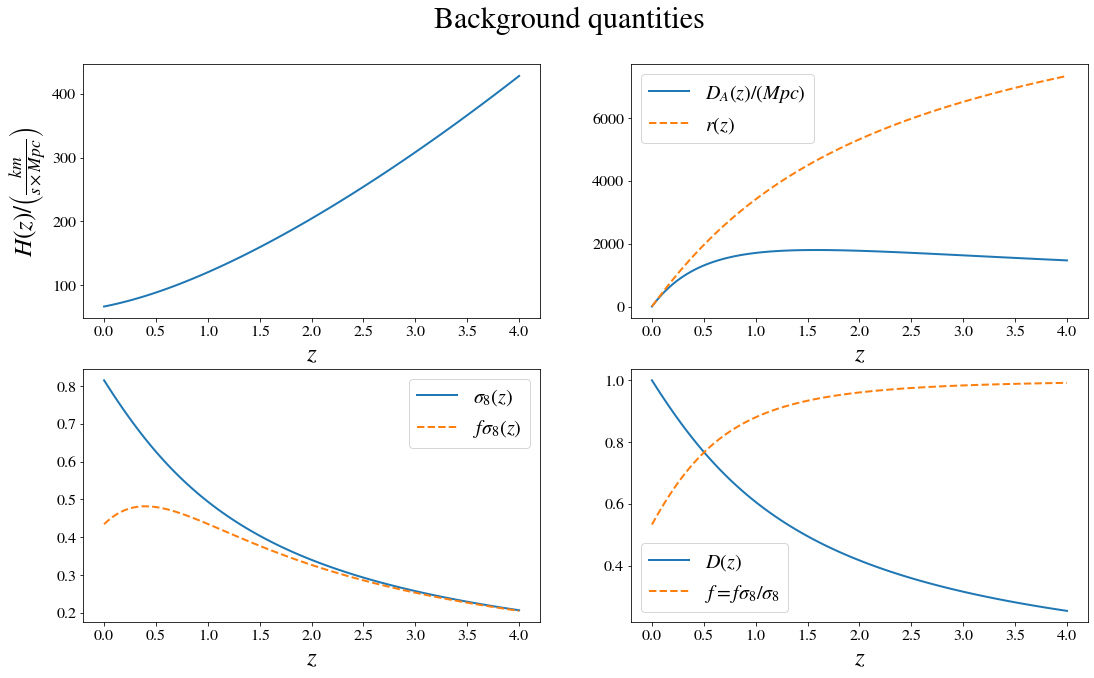

In [13]:
# Let's plot the background quantities of cosmo_dic
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.suptitle('Background quantities')
axs[0, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['H_z_func'](like.cosmo.cosmo_dic['z_win']))
axs[0, 0].set_xlabel(r'$z$')
axs[0, 0].set_ylabel(r'$H(z) / \left( \frac{km}{s\times Mpc}\right)$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['d_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$D_A(z) / (Mpc)$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['r_z_func'](like.cosmo.cosmo_dic['z_win']), '--',
              label = r'$r(z)$')
axs[0, 1].set_xlabel(r'$z$')
axs[0, 1].legend()
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$\sigma_8(z)$')
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f\sigma_8(z)$')
axs[1, 0].set_xlabel(r'$z$')
axs[1, 0].legend()
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['D_z_k'],
              label = r'$D(z)$')
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], 
               like.cosmo.cosmo_dic['f_z'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f = f\sigma_8/\sigma_8$')
axs[1, 1].set_xlabel(r'$z$');
axs[1, 1].legend()
plt.subplots_adjust(top=0.90)

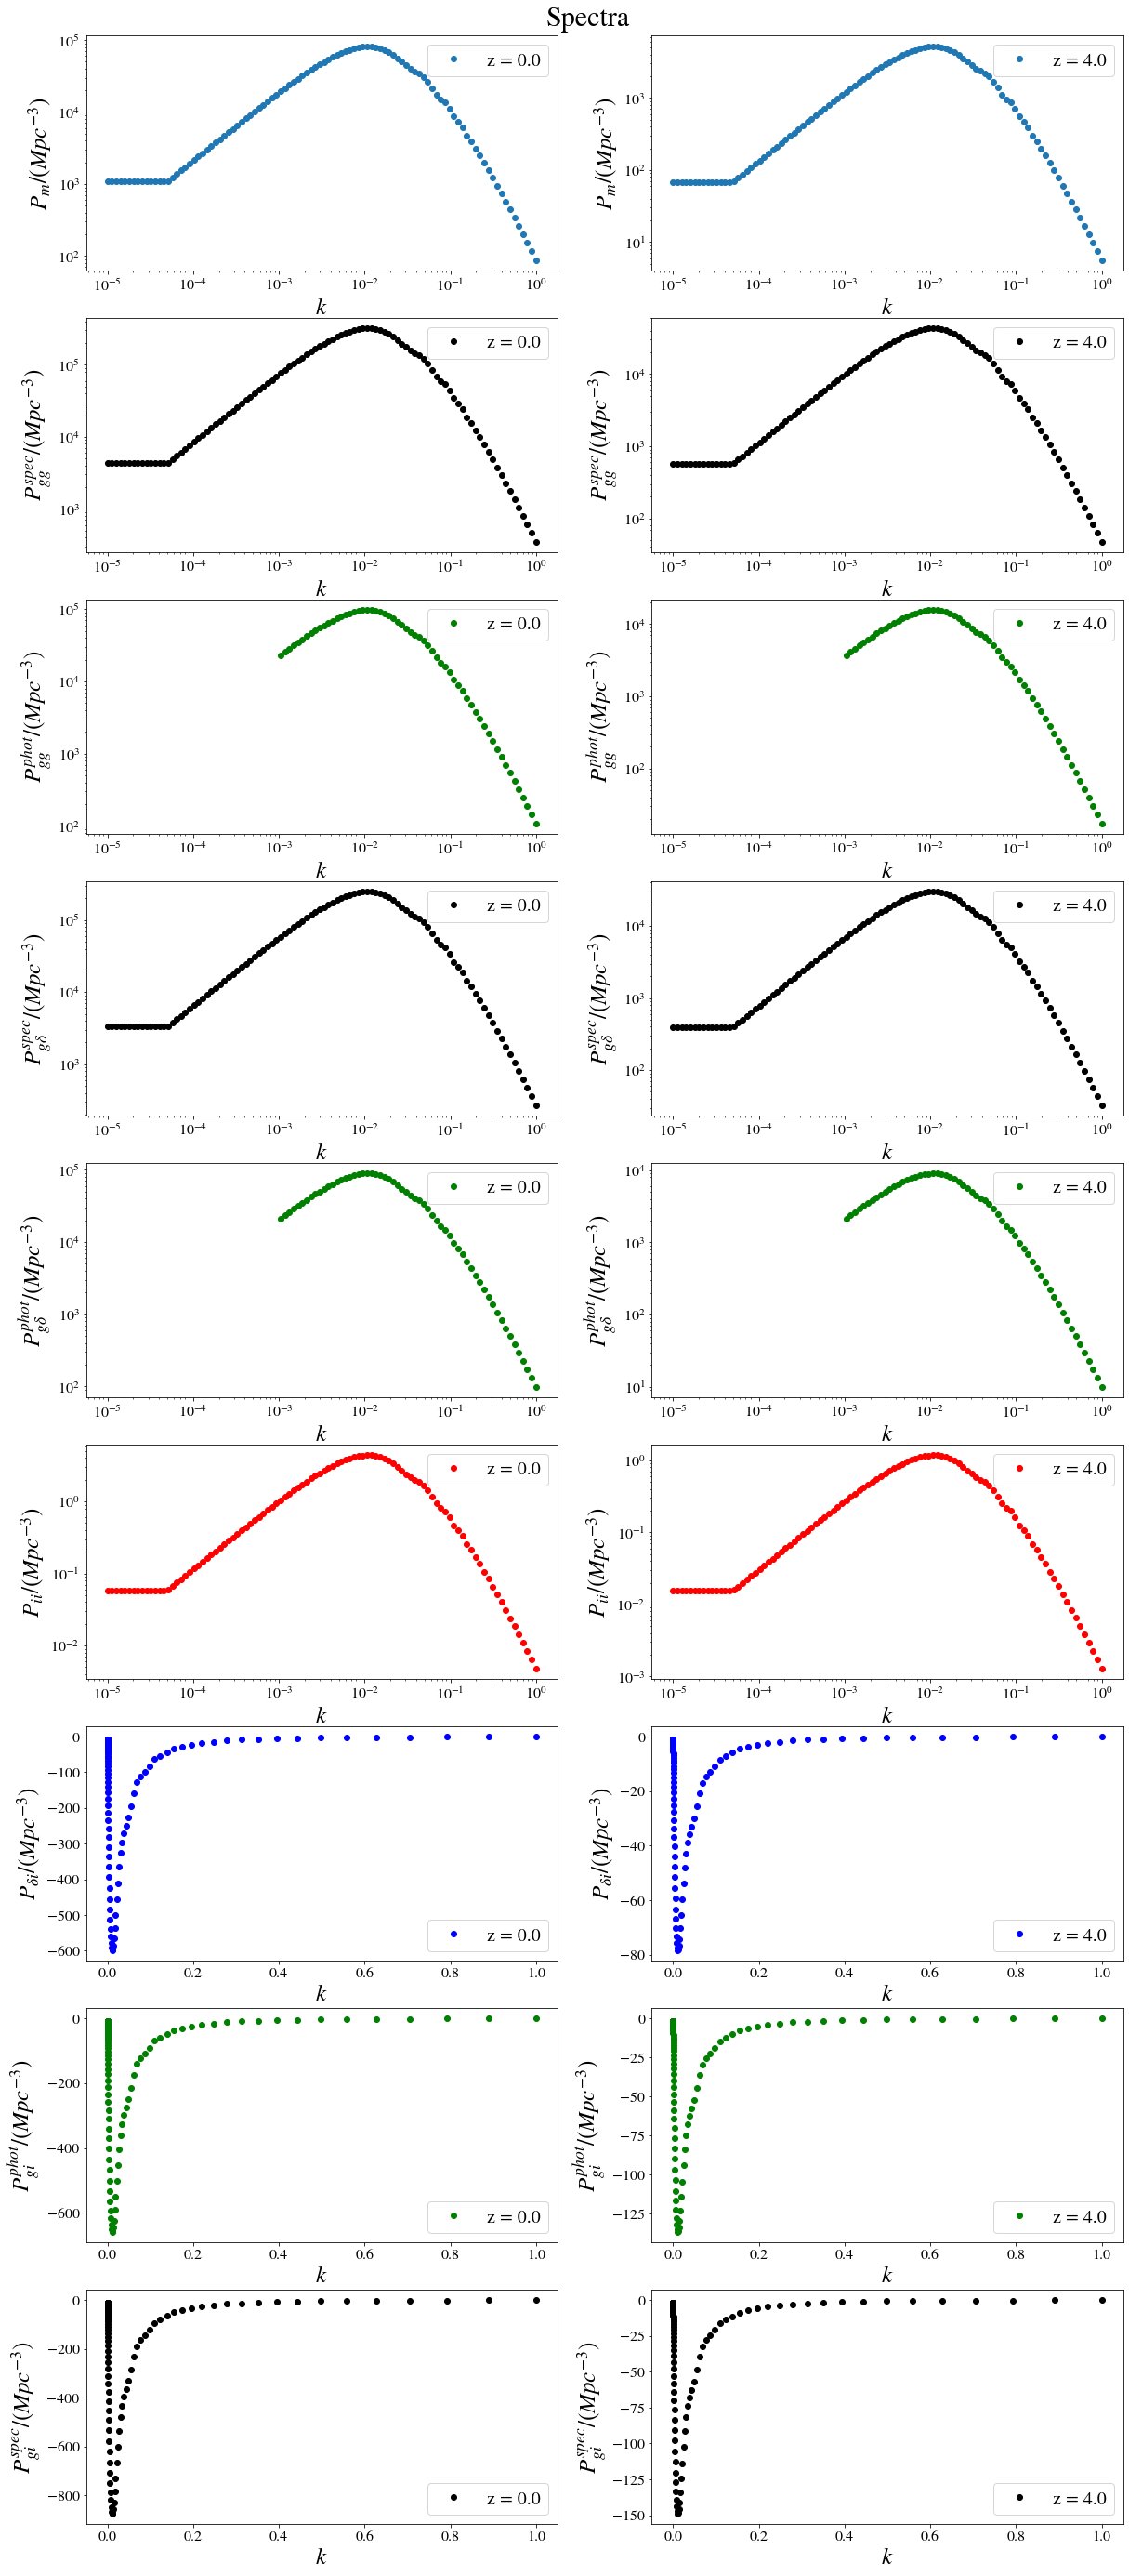

In [25]:
# Let's plot the matter power spectrum and other spectra quantities
# 'Pgg_spec', 'Pgg_phot', 'Pgdelta_phot', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec' 
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

import warnings
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(9, 2, figsize=(20,44))
fig.suptitle('Spectra')
ks=np.logspace(-5, 0, 100)
axs[0, 0].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][0], ks), 'o', 
           label=r"z = {}".format(like.cosmo.cosmo_dic['z_win'][0]))
axs[0, 0].set_xlabel(r'$k$')
axs[0, 0].set_ylabel(r'$P_m / (Mpc^{-3})$')
axs[0, 0].legend()
#------
axs[0, 1].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][-1], ks), 'o', 
           label=r"z = {}".format(like.cosmo.cosmo_dic['z_win'][-1]))
axs[0, 1].set_xlabel(r'$k$')
axs[0, 1].set_ylabel(r'$P_m / (Mpc^{-3})$')
axs[0, 1].legend()
#------

axs[1, 0].loglog(ks, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][0], ks, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[1, 1].loglog(ks, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], ks, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[1, 0].set_xlabel(r'$k$')
axs[1, 0].set_ylabel(r'$P_{gg}^{spec} / (Mpc^{-3})$')
axs[1, 1].set_xlabel(r'$k$')
axs[1, 1].set_ylabel(r'$P_{gg}^{spec} / (Mpc^{-3})$')
axs[1, 0].legend()
axs[1, 1].legend()


#------

axs[2, 0].loglog(ks, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[2, 1].loglog(ks, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[2, 0].set_xlabel(r'$k$')
axs[2, 0].set_ylabel(r'$P_{gg}^{phot} / (Mpc^{-3})$')
axs[2, 1].set_xlabel(r'$k$')
axs[2, 1].set_ylabel(r'$P_{gg}^{phot} / (Mpc^{-3})$')
axs[2, 0].legend()
axs[2, 1].legend()

#------

axs[3, 0].loglog(ks, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][0], ks, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[3, 1].loglog(ks, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], ks, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[3, 0].set_xlabel(r'$k$')
axs[3, 0].set_ylabel(r'$P_{g\delta}^{spec} / (Mpc^{-3})$')
axs[3, 1].set_xlabel(r'$k$')
axs[3, 1].set_ylabel(r'$P_{g\delta}^{spec} / (Mpc^{-3})$')
axs[3, 0].legend()
axs[3, 1].legend()


#------
axs[4, 0].loglog(ks, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[4, 1].loglog(ks, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[4, 0].set_xlabel(r'$k$')
axs[4, 0].set_ylabel(r'$P_{g\delta}^{phot} / (Mpc^{-3})$')
axs[4, 1].set_xlabel(r'$k$')
axs[4, 1].set_ylabel(r'$P_{g\delta}^{phot} / (Mpc^{-3})$')
axs[4, 0].legend()
axs[4, 1].legend()

#------
axs[5, 0].loglog(ks, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'ro', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[5, 1].loglog(ks, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'ro', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[5, 0].set_xlabel(r'$k$')
axs[5, 0].set_ylabel(r'$P_{ii} / (Mpc^{-3})$')
axs[5, 1].set_xlabel(r'$k$')
axs[5, 1].set_ylabel(r'$P_{ii} / (Mpc^{-3})$')
axs[5, 0].legend()
axs[5, 1].legend()

#------
axs[6, 0].plot(ks, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'bo', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[6, 1].plot(ks, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'bo', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[6, 0].set_xlabel(r'$k$')
axs[6, 0].set_ylabel(r'$P_{\delta i} / (Mpc^{-3})$')
axs[6, 1].set_xlabel(r'$k$')
axs[6, 1].set_ylabel(r'$P_{\delta i} / (Mpc^{-3})$')
axs[6, 0].legend(loc=4)
axs[6, 1].legend(loc=4)

#------

axs[7, 0].plot(ks, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[7, 1].plot(ks, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[7, 0].set_xlabel(r'$k$')
axs[7, 0].set_ylabel(r'$P_{gi}^{phot} / (Mpc^{-3})$')
axs[7, 1].set_xlabel(r'$k$')
axs[7, 1].set_ylabel(r'$P_{gi}^{phot} / (Mpc^{-3})$')
axs[7, 0].legend(loc=4)
axs[7, 1].legend(loc=4)

#------

axs[8, 0].plot(ks, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][0], ks), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]))
axs[8, 1].plot(ks, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], ks), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]))
axs[8, 0].set_xlabel(r'$k$')
axs[8, 0].set_ylabel(r'$P_{gi}^{spec} / (Mpc^{-3})$')
axs[8, 1].set_xlabel(r'$k$')
axs[8, 1].set_ylabel(r'$P_{gi}^{spec} / (Mpc^{-3})$')
axs[8, 0].legend(loc=4)
axs[8, 1].legend(loc=4)

plt.subplots_adjust(top=0.97)


<span style='color:magenta'> In the plot above, why is the Pk constant below 10-4? </span>

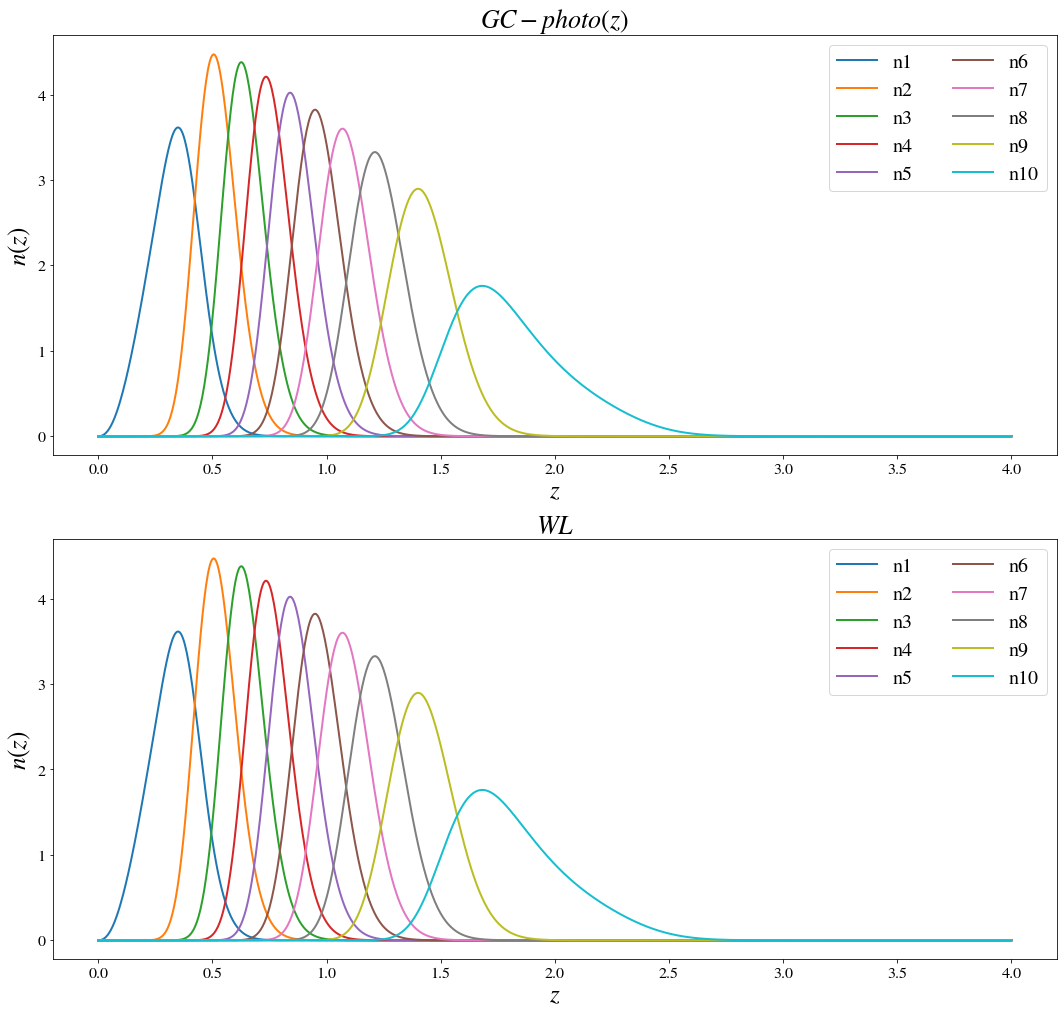

In [15]:
# We can also plot the initial data read by the like_calc module (class Euclike). 
# This data is at the moment the fiducial data store within the data folder of the repository

# DISCLAIMER: the data is read in the reader module, but it is saved as attribute of the Euclike class too.
# The instance of the Euclike class is saved as an attribute of the EuclidLikelihood class as well.

# i.e: let's plot the galaxy distributions for GC-photo(z) and WL (AT THE MOMENT, THEY ARE THE SAME)
zs = np.linspace(0, 4, 1000)
fig, axs = plt.subplots(2, 1, figsize=(18,17))
for key, value in like.likefinal.data_ins.nz_dict_GC_Phot.items():
    axs[0].plot(zs, value(zs), label = key)
for key, value in like.likefinal.data_ins.nz_dict_WL.items():
    axs[1].plot(zs, value(zs), label = key)
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$n(z)$')
axs[0].set_title(r'$GC-photo(z)$')
axs[0].legend(ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$n(z)$')
axs[1].set_title(r'$WL$')
axs[1].legend(ncol=2);
#plt.subplots_adjust(top=0.90)

In [16]:
# We can also plot the window functions for the photometric observables
# For that, you need to import the photo class and read the cosmology dictionary and the n(z) distributions above
from likelihood.photometric_survey.photo import Photo
photo = Photo(like.cosmo.cosmo_dic, like.likefinal.data_ins.nz_dict_WL, like.likefinal.data_ins.nz_dict_GC_Phot)

ATTENTION: WL kernel computation takes some time
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
bin: 8
bin: 9
bin: 10


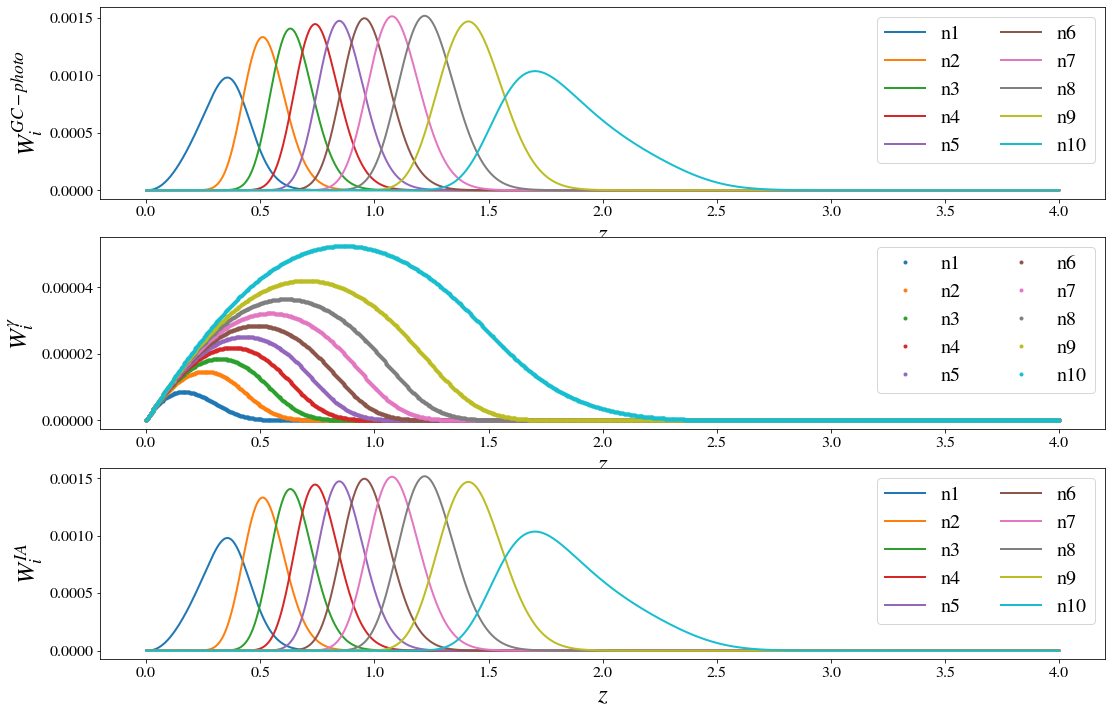

In [17]:
import matplotlib.colors as mcolors
color = list(mcolors.TABLEAU_COLORS.values())
fig, axs = plt.subplots(3, 1, figsize=(18,12))
print('ATTENTION: WL kernel computation takes some time')
# DISCLAIMER: photo.GC_window accepts an array for z, but WL_window does not. 
# This is why we need to go through a foor-loop for WL
for i in range(0, 10):
    print('bin: {}'.format(i+1))
    axs[0].plot(zs, photo.GC_window(zs, i+1), '-', label='n{}'.format(i+1))
    for j, z in enumerate(zs):
        axs[1].plot(z, photo.WL_window(z, i+1), '.', color = color[i], label='n{}'.format(i+1) if j == 0 else "")
    axs[2].plot(zs, photo.IA_window(zs, i+1), label='n{}'.format(i+1))
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$W_i^{GC-photo}$')
axs[0].legend(ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$W_i^{\gamma}$')
axs[1].legend(ncol=2);
axs[2].set_xlabel(r'$z$')
axs[2].set_ylabel(r'$W_i^{IA}$')
axs[2].legend(ncol=2);

### Plot Euclid final observables

We can use the auxiliary module of the Euclid-box to plot the final observables

In [18]:
# We import the Plotter Class
from likelihood.auxiliary.plotter import Plotter

KeyboardInterrupt: 

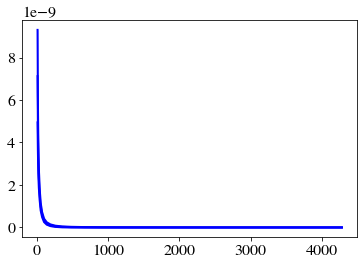

In [19]:
# Weak-Lensing angular power spectrum according to the IST:L recipe 

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

pl_inst = Plotter(cosmo_dic=like.cosmo.cosmo_dic)

ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='WL')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='WL', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Weak-Lensing')
ax1.legend()

In [ ]:
# GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='GC-Phot')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='GC-Phot', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('GC-photo(z)')
ax1.legend()

In [ ]:
# Cross-correlation WL x GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_XC(1, 1, ax1)
ax1 = pl_inst.plot_Cl_XC(np.logspace(1, 3.6, 10), 1, 1, ax1, pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('WL x GC-photo(z)')
ax1.legend()

In [ ]:
# GC-spec observable
# Note: The internal and external spectra are currently plotted seperately 
# due to the fact that the external spectra are supplied in different units. 
## Once this is corrected, this notebook should be editted to place both on the same plot.

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_GC_spec("1.2", 2, ax1, pl_label='a')
ax1.set_xlabel(r'$k$', fontsize=20)
ax1.set_ylabel(r'$P_\ell$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = pl_inst.plot_GC_spec_multipole(1.2, np.linspace(0.01, 0.5), 2, ax2, pl_colour='r', pl_linestyle='--')
ax2.set_xlabel(r'$k$', fontsize=20)
ax2.set_ylabel(r'$P_\ell$', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')